In [26]:
%matplotlib notebook
import matplotlib.pyplot as plt

from topchef_client import Client, NetworkError
from time import sleep
import numpy as np

In [2]:
server_url = 'http://129.97.136.203:5001'
service_id = '5240c47e-071d-448c-a0a2-12be21b7deb8'

client = Client(server_url)
service = client.services[service_id]

def wait_until_job_done(job):
    def is_complete():
        try:
            return job.is_complete
        except NetworkError:
            print 'Network error.'
            return False
    while not is_complete():
        sleep(0.2)

### Adiabatic Power Tuneup

In [3]:
def adiabatic_power_params(adiabatic_power, center_freq=2.87e9, intermediate_freq=0, n_shots=100000, square_pulse_duration=20e-9):
    return {
        'number_of_repetitions': n_shots,
        'meas_time': 800e-9,
        'center_freq': center_freq,
        'intermediate_freq': 0,
        'pulse1_time': square_pulse_duration,
        'pulse1_phase': 0,
        'pulse1_power': 0,
        'pulse1_offset_freq': 0,
        'pulse1_modulation_freq': 0,
        'pulse1_modulation_phase': 0,
        'adiabatic_power': adiabatic_power
    }

<IPython.core.display.Javascript object>


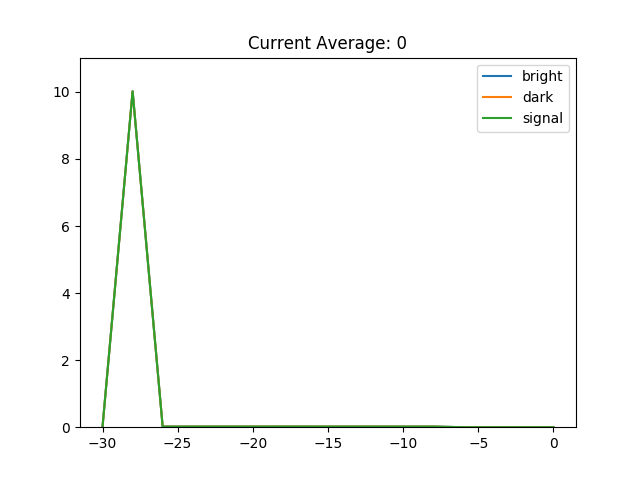

In [ ]:
n_avgs = 100
n_shots_per_avg = 100000
adiabatic_powers = np.linspace(-30, 0, 16)
adiabatic_data = np.zeros((n_avgs,adiabatic_powers.size, 3))
normalized_adiabatic_data = np.zeros((adiabatic_powers.size, 3))

fig = plt.figure()
plt.plot(adiabatic_powers, normalized_adiabatic_data[:,0], label='bright')
plt.plot(adiabatic_powers, normalized_adiabatic_data[:,1], label='dark')
plt.plot(adiabatic_powers, normalized_adiabatic_data[:,2], label='signal')
plt.legend()
def do_plot():
    ax = plt.gca()
    for idx_line, line in enumerate(ax.lines):
        y = np.random.random(size=(100,1))
        line.set_ydata(normalized_adiabatic_data[:,idx_line])
        plt.ylim([0.9 * np.min(normalized_adiabatic_data), 1.1 * np.max(normalized_adiabatic_data)])
        
    plt.title('Current Average: {}'.format(idx_avg))
    fig.canvas.draw()
        

for idx_avg in range(n_avgs):
    for idx_power, adiabatic_power in enumerate(adiabatic_powers):
        eps = adiabatic_power_params(adiabatic_power, n_shots=n_shots_per_avg)
        job = service.new_job(eps)
        wait_until_job_done(job)
        result = job.result
        adiabatic_data[idx_avg, idx_power, :] = result['light_count'], result['dark_count'], result['result_count']
        shots_collected = (idx_avg + 1) * n_shots_per_avg
        normalized_adiabatic_data[idx_power] = np.sum(adiabatic_data[:,idx_power,:],axis=0) / shots_collected
        do_plot()
        

<IPython.core.display.Javascript object>


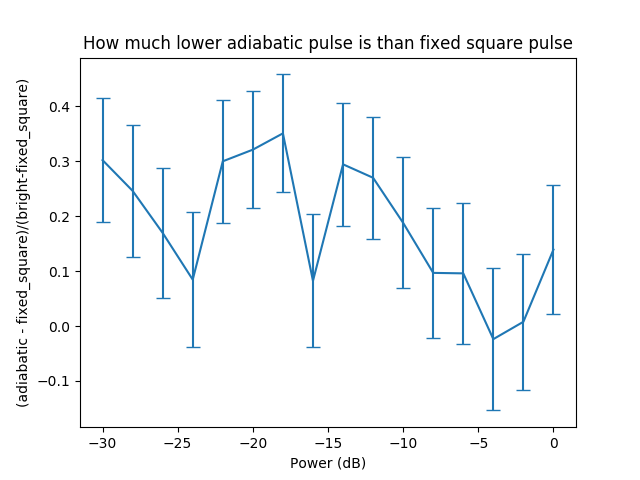

In [12]:
fig = plt.figure()

a, b = np.sum(adiabatic_data[:,:,0],axis=0), np.sum(adiabatic_data[:,:,2],axis=0)
p = (np.sum(adiabatic_data[:,:,1],axis=0) - b) / (a - b)
e = np.sqrt((p*(1+p)*a + (p-2) * (p-1) * b) / (a-b)**2)

plt.errorbar(adiabatic_powers, p, yerr=e, capsize=5)

plt.xlabel('Power (dB)')
plt.ylabel('(adiabatic - fixed_square)/(bright-fixed_square)')
plt.title('How much lower adiabatic pulse is than fixed square pulse')

### Measurement Window Optimization

In [ ]:
def meas_time_params(meas_time, center_freq=2.87e9, intermediate_freq=0, n_shots=100000):
    return {
        'number_of_repetitions': n_shots,
        'meas_time': meas_time,
        'center_freq': center_freq,
        'intermediate_freq': 0,
        'pulse1_time': 25e-9,
        'pulse1_phase': 0,
        'pulse1_power': 0,
        'pulse1_offset_freq': 0,
        'pulse1_modulation_freq': 0,
        'pulse1_modulation_phase': 0,
        'adiabatic_power': -2
    }

In [ ]:
n_avgs = 20
n_shots_per_avg = 100000
meas_times = np.linspace(100e-9, 1.5e-6, 29)
meas_data = np.zeros((n_avgs,meas_times.size, 3))
normalized_meas_data = np.zeros((meas_times.size, 3))

fig = plt.figure()
for idx, my_label in enumerate(['bright','dark','signal']):
    plt.plot(
        meas_times, 
        normalized_meas_data[:,idx],
        label=my_label
    )
plt.legend()
def do_plot():
    ax = plt.gca()
    for idx_line, line in enumerate(ax.lines):
        line.set_ydata(normalized_meas_data[:,idx_line])
        plt.ylim([0.9 * np.min(normalized_meas_data), 1.1 * np.max(normalized_meas_data)])
    plt.title('Current Average: {}'.format(idx_avg))
    fig.canvas.draw()
        

for idx_avg in range(n_avgs):
    for idx_meas, meas_time in enumerate(meas_times):
        eps = meas_time_params(meas_time, n_shots=n_shots_per_avg)
        job = service.new_job(eps)
        wait_until_job_done(job)
        result = job.result
        counts = np.array([result['light_count'], result['dark_count'], result['result_count']])
        if counts[0] > 1e6:
            counts = counts - 1e6
        meas_data[idx_avg, idx_meas, :] = counts
        shots_collected = (idx_avg + 1) * n_shots_per_avg
        normalized_meas_data[idx_meas] = np.sum(meas_data[:,idx_meas,:],axis=0) / shots_collected
        do_plot()
        

<IPython.core.display.Javascript object>


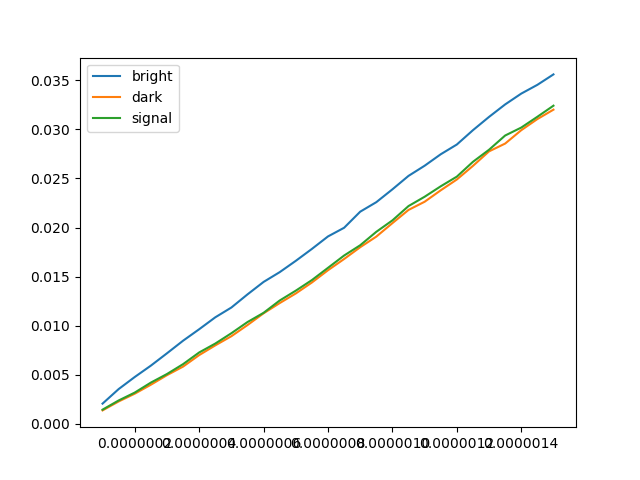

In [13]:
fig = plt.figure()
for idx, my_label in enumerate(['bright','dark','signal']):
    plt.plot(
        meas_times, 
        normalized_meas_data[:,idx],
        label=my_label
    )
plt.legend()

### Rabi Experiment Tester

In [3]:
def rabi_experiment_params(duration, power_db=0, meas_time=800e-9, offset_freq=0, modulation_freq=0, n_shots=50000, precede_by_tracking=False):
    return {
        'number_of_repetitions': n_shots,
        'meas_time': meas_time,
        'center_freq': 2.87e9,
        'intermediate_freq': 0,
        'pulse1_time': duration,
        'pulse1_phase': 0,
        'pulse1_power': power_db,
        'pulse1_offset_freq': offset_freq,
        'pulse1_modulation_freq': modulation_freq,
        'pulse1_modulation_phase': 0,
        'adiabatic_power': -2,
        'precede_by_tracking': precede_by_tracking
    }

<IPython.core.display.Javascript object>


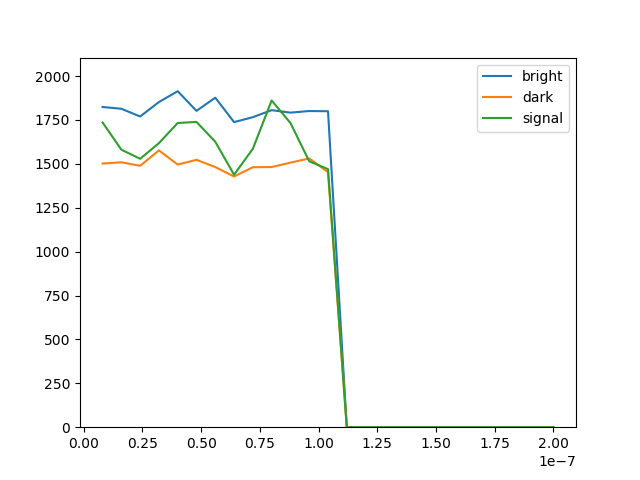

KeyboardInterrupt: 

In [25]:
n_avgs = 100
pulse_times = np.linspace(0, 200e-9, 26)[1:]
data = np.zeros((n_avgs,pulse_times.size, 3))

fig = plt.figure()
plt.plot(pulse_times, np.sum(data[:,:,0],axis=0), label='bright')
plt.plot(pulse_times, np.sum(data[:,:,1],axis=0), label='dark')
plt.plot(pulse_times, np.sum(data[:,:,2],axis=0), label='signal')
plt.legend()
def do_plot():
    ax = plt.gca()
    for idx_line, line in enumerate(ax.lines):
        y = np.random.random(size=(100,1))
        line.set_ydata(np.sum(data[:,:,idx_line], axis=0))
        plt.ylim([0.9 * np.min(np.sum(data, axis=0)), 1.1 * np.max(np.sum(data, axis=0))])
    fig.canvas.draw()
        

for idx_avg in range(n_avgs):
    for idx_pulse_time, pulse_time in enumerate(pulse_times):
        eps = rabi_experiment_params(pulse_time, n_shots=100000)
        job = service.new_job(eps)
        wait_until_job_done(job)
        result = job.result
        counts = np.array([result['light_count'], result['dark_count'], result['result_count']])
        if counts[0] > 1e6:
            counts = counts - 1e6
        data[idx_avg, idx_pulse_time, :] = counts
        do_plot()
        


### Timing

In [7]:
def run_job(meas_time, n_shots=200000):
    job = service.new_job(rabi_experiment_params(10e-9, n_shots=n_shots, meas_time=meas_time))
    wait_until_job_done(job)

In [32]:
%timeit -n 1 -r 1 service.new_job(rabi_experiment_params(10e-9))

1 loop, best of 1: 3.26 s per loop


In [39]:
job = service.new_job(rabi_experiment_params(10e-9))

In [40]:
%timeit -n 3 job.is_complete

3 loops, best of 3: 12.2 ms per loop


First run an experiment that we know is stored in cache three times.

In [30]:
run_job(800e-9)
%timeit -n 3 -r 1 run_job(800e-9)

3 loops, best of 1: 14.2 s per loop


Now run three experiments in a loop that are definitely not in the cache.

In [31]:
%timeit -n 1 -r 1 run_job(802e-9)

KeyboardInterrupt: 

In [10]:
%timeit -n 1 -r 1 run_job(798e-9)

1 loop, best of 1: 7.65 s per loop


In [15]:
%timeit -n 1 -r 1 run_job(794e-9, n_shots=100000)

1 loop, best of 1: 4.64 s per loop


### Single Job

In [39]:
job = service.new_job(rabi_experiment_params(400e-9, n_shots=200000))
wait_until_job_done(job)
print job.result

{u'dark_count': 875, u'light_count': 889, u'time_completed': u'2017-12-22T13:38:19.081-05:00', u'result_count': 873}


In [17]:
job = service.new_job(rabi_experiment_params(20e-9, n_shots=200000, precede_by_tracking=True))
wait_until_job_done(job)
print job.result

{u'dark_count': 1003564, u'light_count': 1004043, u'time_completed': u'2017-12-19T21:21:57.289-05:00', u'result_count': 1003448}
